# Sec. IV: Search for geodesics on manifolds

In [ ]:
from matplotlib import pyplot as plt, cm, colors
from mpl_toolkits.mplot3d import Axes3D

import pickle
from functools import partial
from collections import OrderedDict
import numpy as np
import torch
from torch import nn
import seaborn as sns
from tqdm import tqdm


plt.rcParams.update(
    {"text.usetex": True, "font.family": "sans-serif", "font.sans-serif": ["Helvetica"]}
)
# for Palatino and other serif fonts use:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    }
)
# It's also possible to use the reduced notation by directly setting font.family:
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

In [17]:
class Interpolation(nn.Module):
    def __init__(self, dim_layers, endpoint1, endpoint2):
        super(Interpolation, self).__init__()
        assert isinstance(
            dim_layers, list
        ), 'Type of parameter "dim_layers" should be list.'
        self.endpoint1 = endpoint1
        self.endpoint2 = endpoint2

        self.net = nn.Sequential(
            OrderedDict([("dense_0", nn.Linear(1, dim_layers[0]))])
        )

        for i in range(1, len(dim_layers)):
            self.net.add_module(
                "batchNorm_{:d}".format(i - 1), nn.BatchNorm1d(dim_layers[i - 1])
            )
            self.net.add_module("relu_{:d}".format(i - 1), nn.ReLU(True))
            self.net.add_module(
                "dense_{:d}".format(i), nn.Linear(dim_layers[i - 1], dim_layers[i])
            )
        # self.net.add_module('tanh', nn.Tanh())

    def forward(self, inputs):
        output = self.net(inputs)
        return (
            output
            - (inputs * output[-1] + (1 - inputs) * output[0])
            + (inputs * self.endpoint2 + (1 - inputs) * self.endpoint1)
        )

## Eq. (5) from paper:

$
\mathrm{cost}(\gamma)=\sum\limits_{i=0}^{n-1} \log^2\left(\mathcal{Q}(\gamma(\tfrac{t_i+t_{i+1}}{2}))\right) \cdot\frac{\|\Phi(\gamma(t_{i+1}))-\Phi(\gamma(t_i))\|_H^2}{t_{i+1}-t_i}
$

In [18]:
def loss(t, fun_Q, fun_phi, model):
    t_avg = (torch.roll(t, -1, dims=0) + t) / 2  # (t_{i+1} + t_i) / 2
    gamma_avg = model(t_avg[:-1, :])
    first_part = torch.log(fun_Q(gamma_avg)).square()
    gamma = model(t)
    phi_val = fun_phi(gamma)
    # norm2 = torch.norm(torch.roll(phi_val, -1, dims=0) - phi_val, p=2, dim=1, keepdim=True).square()
    norm2 = torch.square(torch.roll(phi_val, -1, dims=0) - phi_val).sum(
        dim=1, keepdim=True
    )
    second_part = norm2 / (torch.roll(t, -1, dims=0) - t)
    return torch.sum(first_part * second_part[:-1, :], dim=0, keepdim=False)

# Ex. 1

Consider a trivial case of $Z=\mathbb{R}^2$. Let $\mathcal{Q}=1/2$ and $\Phi$ be the identity function. Take two endpoints $z_0 = (0, 1)^T$, $z_1 = (1, 0)^T$ and search for a geodesic $\gamma\colon [0, 1]\to Z$ connecting $z_1$ and $z_2$ by optimising the cost function in Eq. (5) in paper.

In [56]:
def Q(x):
    return torch.full((x.shape[0], 1), 0.5, dtype=x.dtype, device=x.device)


def phi(z):
    return z

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\033[0;1;34mDevice: {device}\033[0m")

z0 = torch.tensor([[0.0, 1]], device=device, requires_grad=False)
z1 = torch.tensor([[1.0, 0]], device=device, requires_grad=False)

model = Interpolation([2, 2], z0, z1).to(device)
model

Device: cpu


Interpolation(
  (net): Sequential(
    (dense_0): Linear(in_features=1, out_features=2, bias=True)
    (batchNorm_0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_0): ReLU(inplace=True)
    (dense_1): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [58]:
optim = torch.optim.Adam(
    model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0
)

test = torch.linspace(start=0.0, end=1.0, steps=20, dtype=None, device=None).view(-1, 1)

loss_val = []
num_epoch = 100
interval, interval_list = 2, [5, 10]
# interval, interval_list = 1, [4, 7]
plot_data = {}

for epoch in tqdm(range(num_epoch), leave=False):
    if epoch % interval == 0:
        plot_data[f"epoch_{epoch}"] = model(test).detach().cpu().numpy()

    batch = torch.rand(20, 1, dtype=torch.float32, device=device, requires_grad=False)
    batch, _ = batch.sort(dim=0, descending=False)
    batch[0, 0] = 0
    batch[-1, 0] = 1

    cost = loss(batch, Q, phi, model)
    optim.zero_grad()
    cost.backward()
    optim.step()
    loss_val.append(cost.item())

    if (epoch + 1) % 10 == 0:
        try:
            interval = interval_list.pop(0)
        except IndexError:
            pass

plot_data[f"epoch_{num_epoch}"] = model(test).detach().cpu().numpy()

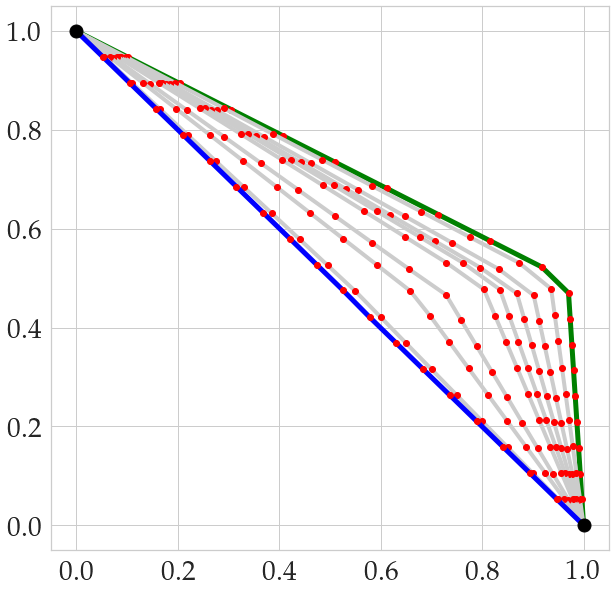

In [19]:
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2.5)


selected_epoch = [2, 4, 6, 8, 10, 15, 20, 30]

fig = plt.figure(figsize=(10, 10))
arr = plot_data[f"epoch_0"]
plt.plot(arr[:, 0], arr[:, 1], "g-", linewidth=5, markersize=12)
plt.plot(arr[:, 0], arr[:, 1], "ro")
for key in selected_epoch:
    arr = plot_data[f"epoch_{key}"]
    plt.plot(
        arr[:, 0], arr[:, 1], color="0.8", linestyle="-", linewidth=4
    )
    plt.plot(arr[:, 0], arr[:, 1], "ro")
arr = plot_data[f"epoch_{num_epoch}"]
plt.plot(arr[:, 0], arr[:, 1], "b-", linewidth=5, markersize=12)
plt.plot(arr[:, 0], arr[:, 1], "ro")

plt.plot(
    [arr[0, 0], arr[-1, 0]], [arr[0, 1], arr[-1, 1]], "ko", linewidth=2, markersize=13
)

plt.show()
plt.close(fig)

# Ex. 2

We search now for a geodesic $\gamma\colon [0, 1]\to Z$ connecting $z_0=(0,1)^T$, $z_1=(1,0)^T$ on a half-sphere $Z=\mathbb{R}^2$ using cost function in Eq. (5) (paper). Let $\mathcal{Q}=1/2$ and 
$\Phi(z) = (0,0,1)^T + \left((z,0)^T - (0,0,1)^T\right)/\|(z,0)^T - (0,0,1)^T\|$ 
be given.

In [8]:
def Q(x):
    return torch.full((x.shape[0], 1), 0.5, dtype=x.dtype, device=x.device)


def phi(z):
    tmp = torch.tensor(
        [[0.0, 0, 1]], dtype=z.dtype, device=z.device, requires_grad=False
    )
    z_ = torch.cat(
        (z, torch.zeros(z.shape[0], 1, dtype=z.dtype, device=z.device)), dim=1
    )
    temp = z_ - tmp
    return tmp + temp / torch.norm(temp, p=2, dim=1, keepdim=True)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\033[0;1;34mDevice: {device}\033[0m")

z0 = torch.tensor([[0.0, 1]], device=device, requires_grad=False)
z1 = torch.tensor([[1.0, 0]], device=device, requires_grad=False)

model = Interpolation([2, 2], z0, z1).to(device)
model

Device: cpu


Interpolation(
  (net): Sequential(
    (dense_0): Linear(in_features=1, out_features=2, bias=True)
    (batchNorm_0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_0): ReLU(inplace=True)
    (dense_1): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [34]:
optim = torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.999), weight_decay=0)

test = torch.linspace(start=0.0, end=1.0, steps=10, dtype=None, device=None).view(-1, 1)

loss_val = []
num_epoch = 100
interval, interval_list = 1, [2, 5, 10]
# interval, interval_list = 5, [10, 25]
plot_data = {}

for epoch in tqdm(range(num_epoch), leave=False):
    if epoch % interval == 0:
        plot_data[f"epoch_{epoch}"] = model(test).detach().cpu().numpy()

    batch = torch.rand(25, 1, dtype=torch.float32, device=device, requires_grad=False)
    batch, _ = batch.sort(dim=0, descending=False)
    batch[0, 0] = 0
    batch[-1, 0] = 1

    cost = loss(batch, Q, phi, model)
    optim.zero_grad()
    cost.backward()
    optim.step()
    loss_val.append(cost.item())

    if (epoch + 1) % 10 == 0:
        try:
            interval = interval_list.pop(0)
        except IndexError:
            pass

plot_data[f"epoch_{num_epoch}"] = model(test).detach().cpu().numpy()

<IPython.core.display.Javascript object>


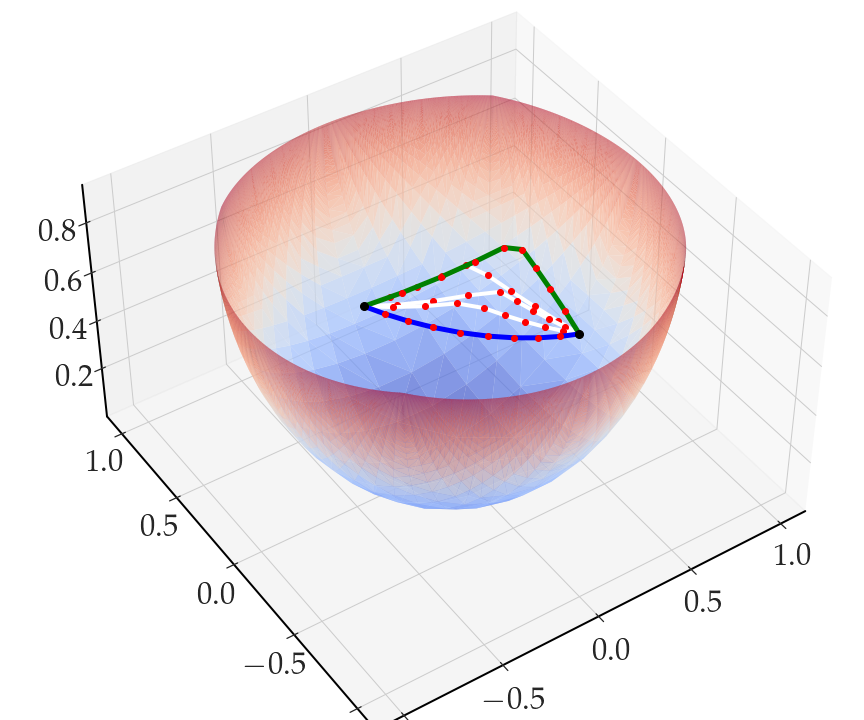

In [26]:
%matplotlib notebook

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2.8)


n = 100
data = np.array(
    np.meshgrid(
        np.linspace(-10, 10, n, endpoint=True), np.linspace(-10, 10, n, endpoint=True)
    )
).T.reshape(-1, 2)

data = phi(torch.from_numpy(data)).detach().numpy()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

ax.plot_trisurf(
    data[:, 0],
    data[:, 1],
    data[:, 2],
    color="g",
    edgecolor="none",
    linewidth=0.1,
    antialiased=True,
    alpha=0.7,
    cmap=cm.coolwarm,
)

# selected_epoch = [1, 2, 3, 4, 5] #, 6, 7, 8, 9, 10, 12, 14, 16]
selected_epoch = [1, 2, 3]

for key in selected_epoch:
    path = phi(torch.from_numpy(plot_data[f"epoch_{key}"])).detach().numpy()
    ax.plot(path[:, 0], path[:, 1], path[:, 2], color="1", linestyle="-", linewidth=4)
    ax.plot(path[:, 0], path[:, 1], path[:, 2], "ro", markersize=6)

path = phi(torch.from_numpy(plot_data["epoch_0"])).detach().numpy()
ax.plot(path[:, 0], path[:, 1], path[:, 2], "g-", linewidth=5)
ax.plot(path[:, 0], path[:, 1], path[:, 2], "ro", markersize=6)

path = phi(torch.from_numpy(plot_data[f"epoch_{num_epoch}"])).detach().numpy()
ax.plot(path[:, 0], path[:, 1], path[:, 2], "b-", linewidth=5)
ax.plot(path[:, 0], path[:, 1], path[:, 2], "ro", markersize=6)

ax.plot(
    [path[0, 0], path[-1, 0]],
    [path[0, 1], path[-1, 1]],
    [path[0, 2], path[-1, 2]],
    "ko",
    linewidth=2,
    markersize=8,
)

ax.set_box_aspect(aspect=(1, 1, 0.6))

azim = -124
dist = 7
elev = 42
ax.azim = azim
ax.dist = dist
ax.elev = elev

ax.w_xaxis.line.update({"linewidth": 2, "color": "k"})
ax.w_yaxis.line.update({"linewidth": 2, "color": "k"})
ax.w_zaxis.line.update({"linewidth": 2, "color": "k"})

plt.show()
# plt.close(fig)

# Ex. 3

Let $M$ be a plane with a cut-out disk with the centre (0, 0) and radius 1. Let us define a metric that is zero on $M$ and positive outside of it
\begin{align*}
d_M(z) & = \max(0, 1-\|z\|_2), \\
\mathcal{Q}(z) & = \tfrac{1}{2}\exp(-5 d_M(z)).
\end{align*}
Using the cost function from Eq. (5) in paper (with $\Phi$ an identity function),  we search for a geodesic $\gamma\colon[0, 1]\to\mathbb{R}^2$ connecting $z_0=(-1.3, 0)^T$ and $z_1=(1.3, 0)^T$.

In [203]:
def Q(x, K=5):
    tmp = 1 - torch.norm(x, p=2, dim=1, keepdim=True)
    dist = torch.where(tmp > 0, tmp, torch.tensor(0.0, dtype=x.dtype, device=x.device))
    return torch.exp(-K * dist) / 2


def phi(z):
    return z

In [217]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\033[0;1;34mDevice: {device}\033[0m")

z0 = torch.tensor([[-1.3, 0.0]], device=device, requires_grad=False)
z1 = torch.tensor([[1.3, 0.0]], device=device, requires_grad=False)

model = Interpolation([4, 2], z0, z1).to(device)
model

Device: cpu


Interpolation(
  (net): Sequential(
    (dense_0): Linear(in_features=1, out_features=4, bias=True)
    (batchNorm_0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_0): ReLU(inplace=True)
    (dense_1): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [218]:
lr = 0.01
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0)

# use_scheduler = False
use_scheduler = True
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optim, lr_lambda=lambda epoch: max(0.99**epoch, 1e-4 / lr)
    )
    #     scheduler = torch.optim.lr_scheduler.LambdaLR(
    #         optim, lr_lambda=lambda epoch: 0.99 ** epoch if (epoch + 1) % 10 else 1
    #     )
    #     scheduler = torch.optim.lr_scheduler.CyclicLR(
    #         optim, base_lr=0.001, max_lr=lr, step_size_up=50, mode="triangular2", cycle_momentum=False
    #     )
    lrs = []

test = torch.linspace(start=0.0, end=1.0, steps=10, dtype=None, device=None).view(-1, 1)

loss_val = []
num_epoch = 500
interval, interval_list = 2, [4, 8, 10, 25]
plot_data = {}

vals_k = []
# start_k, end_k = 1, 10
start_k, end_k = 5, 5
for epoch in tqdm(range(num_epoch), leave=False):
    k = min(1, epoch / (num_epoch * 0.8))
    k = k * end_k + (1 - k) * start_k
    vals_k.append(k)

    if epoch % interval == 0:
        plot_data[f"epoch_{epoch}"] = model(test).detach().cpu().numpy()

    batch = torch.rand(50, 1, dtype=torch.float32, device=device, requires_grad=False)
    batch, _ = batch.sort(dim=0, descending=False)
    batch[0, 0] = 0
    batch[-1, 0] = 1

    cost = loss(batch, partial(Q, K=k), phi, model)
    optim.zero_grad()
    cost.backward()
    optim.step()
    loss_val.append(cost.item())

    if (epoch + 1) % 10 == 0:
        try:
            interval = interval_list.pop(0)
        except IndexError:
            pass
    if use_scheduler:
        scheduler.step()
        lrs.append(optim.param_groups[0]["lr"])

plot_data[f"epoch_{num_epoch}"] = model(test).detach().cpu().numpy()

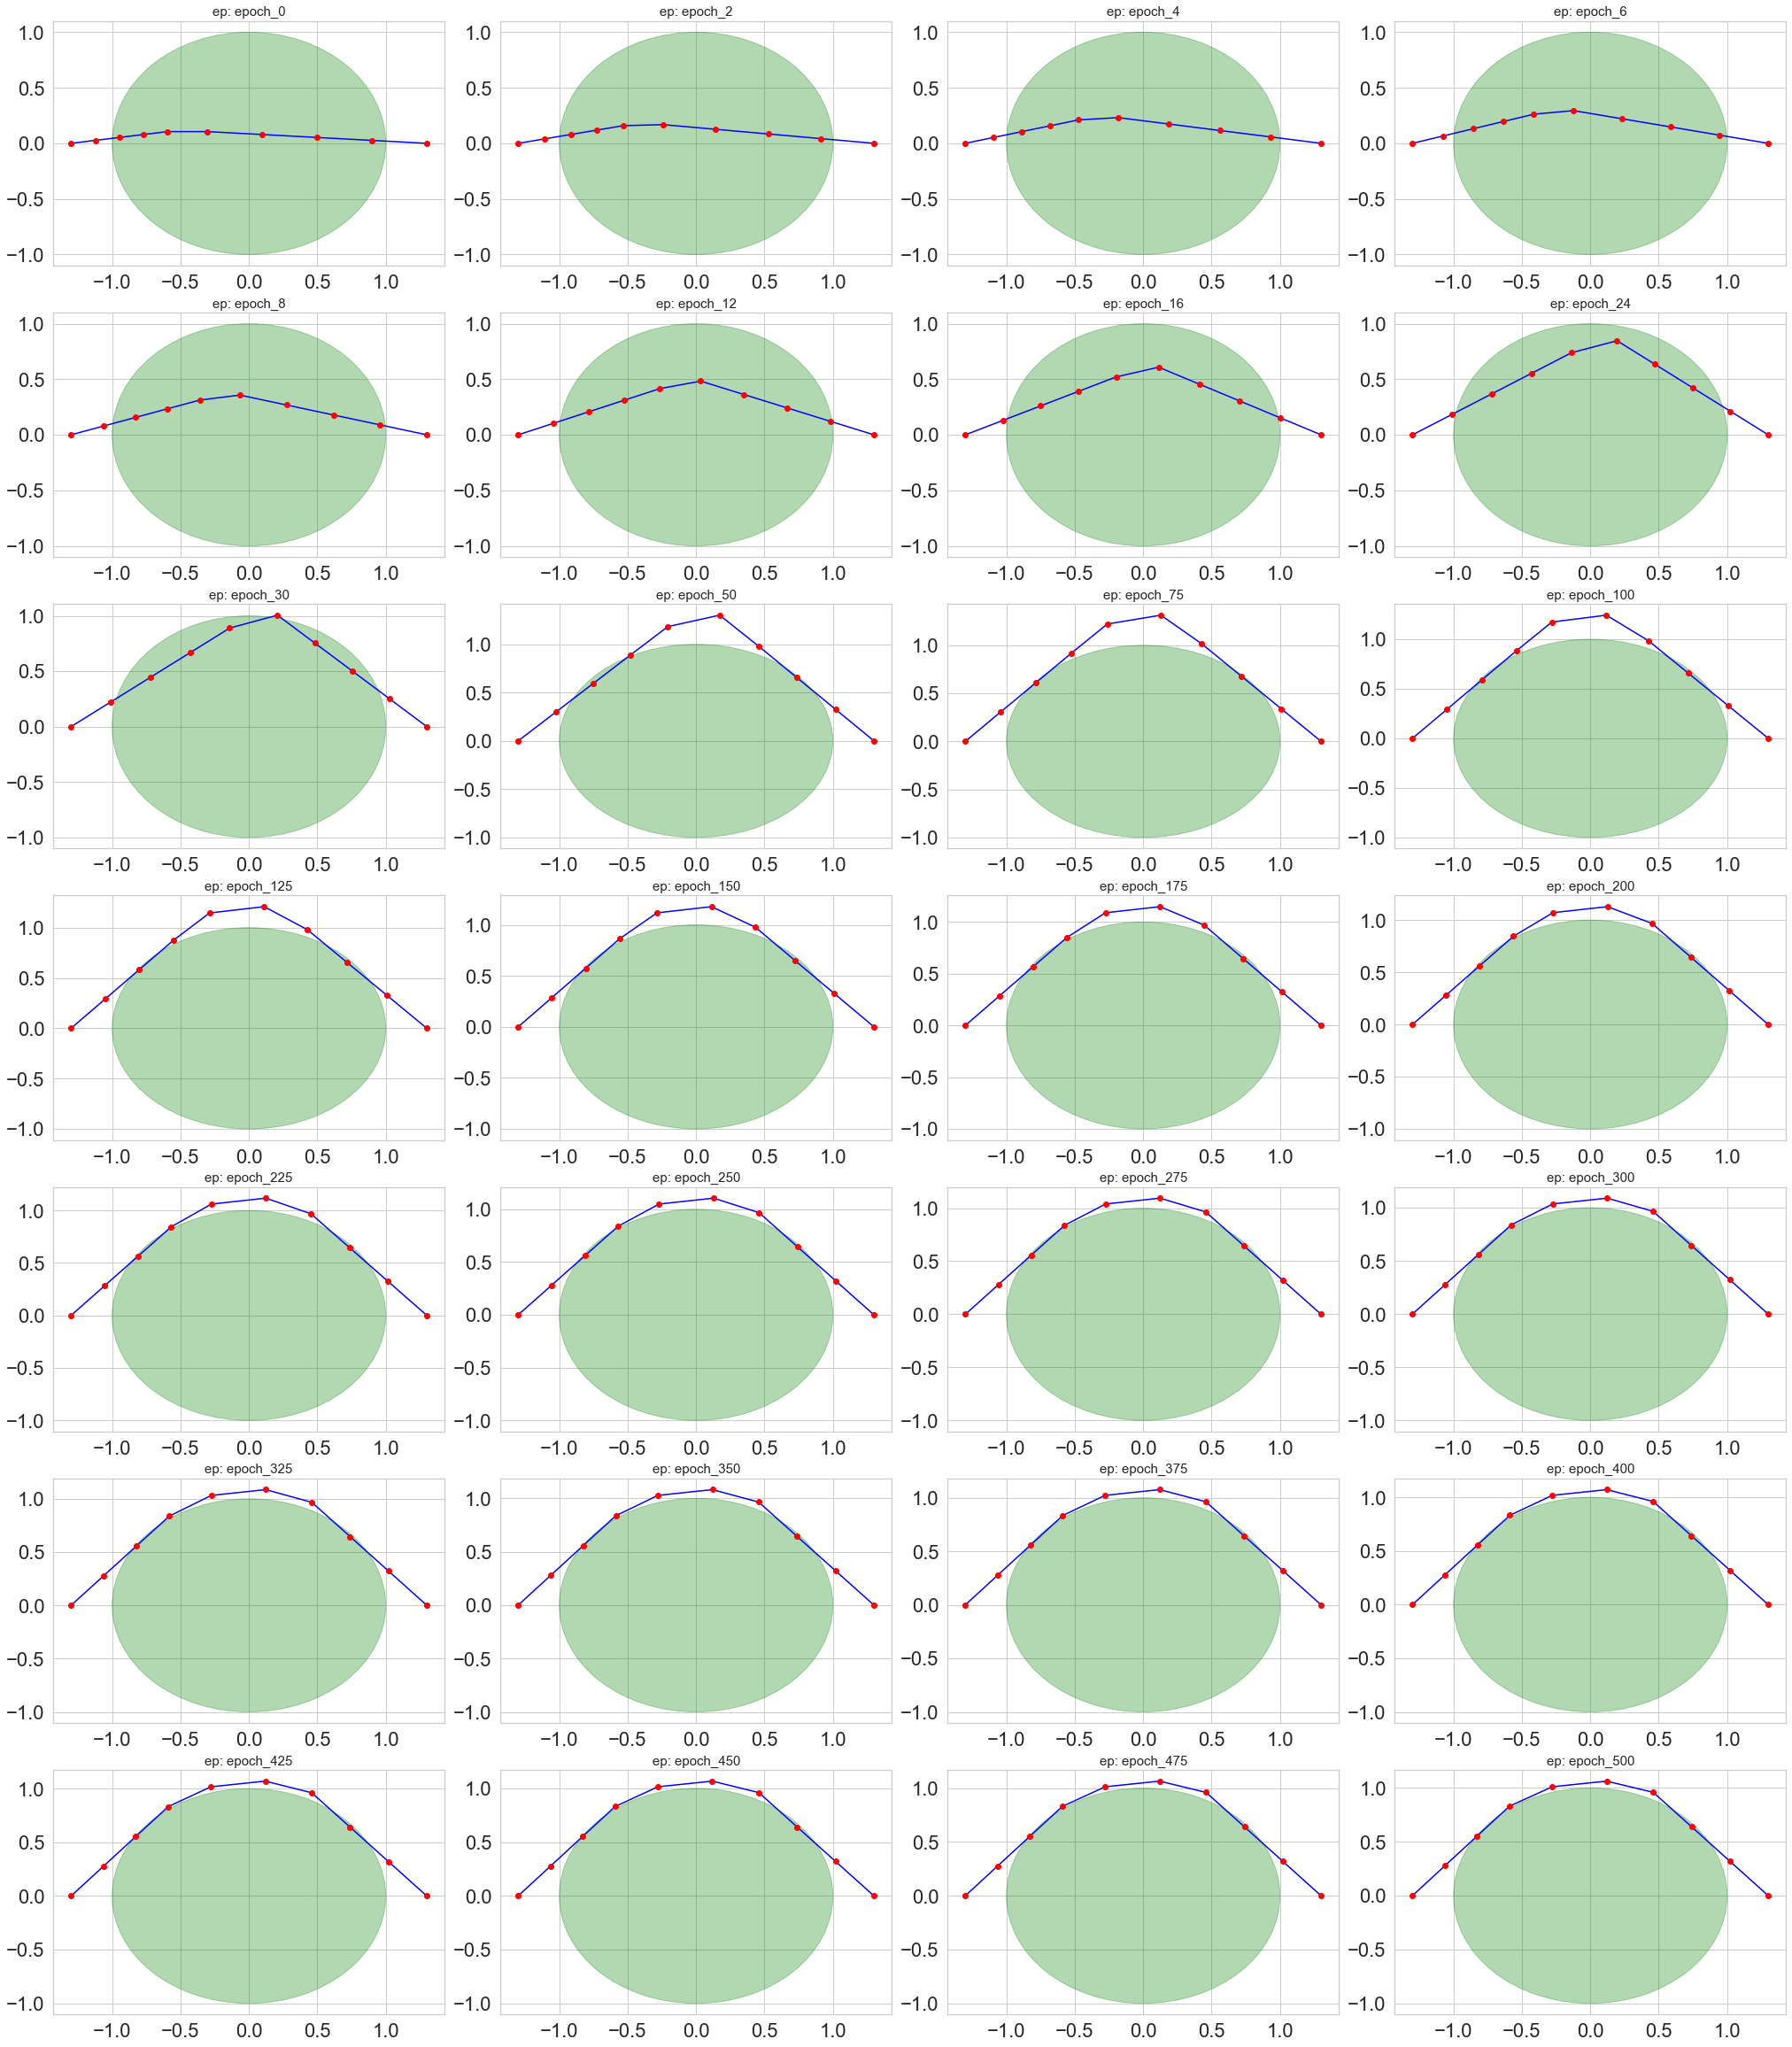

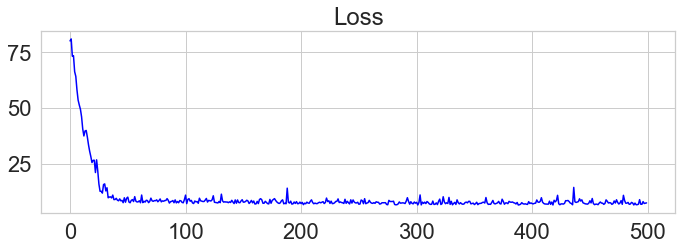

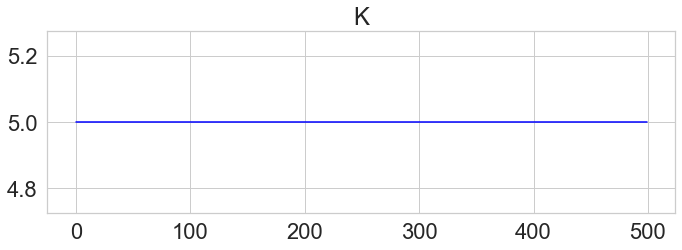

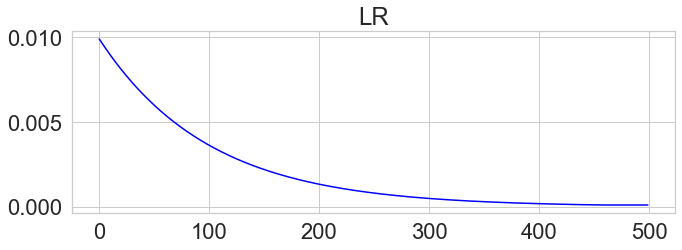

In [219]:
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)


ncols = 4
nrows, r = divmod(len(plot_data), ncols)
nrows = nrows + 1 if r > 0 else nrows

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(4 * nrows, 8 * ncols), constrained_layout=True
)

for i, (key, arr) in enumerate(plot_data.items()):
    circle = plt.Circle((0, 0), 1.0, color="g", fill=True, alpha=0.3)
    r, c = divmod(i, ncols)
    axs[r, c].plot(arr[:, 0], arr[:, 1], "b-")
    axs[r, c].plot(arr[:, 0], arr[:, 1], "ro")
    axs[r, c].set_title(f"ep: {key}", fontsize=15)
    axs[r, c].add_patch(circle)

for i in range(len(plot_data), nrows * ncols):
    r, c = divmod(i, ncols)
    axs[r, c].axis("off")

plt.show()
plt.close(fig)

# =========================================

plt.figure(figsize=(10, 4))
plt.plot(range(len(loss_val)), loss_val, c="b")
plt.title("Loss")
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(10, 4))
plt.plot(range(len(vals_k)), vals_k, c="b")
plt.title("K")
plt.tight_layout()
plt.show()
plt.close()

if use_scheduler:
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(lrs)), lrs, c="b")
    plt.title("LR")
    plt.tight_layout()
    plt.show()
    plt.close()

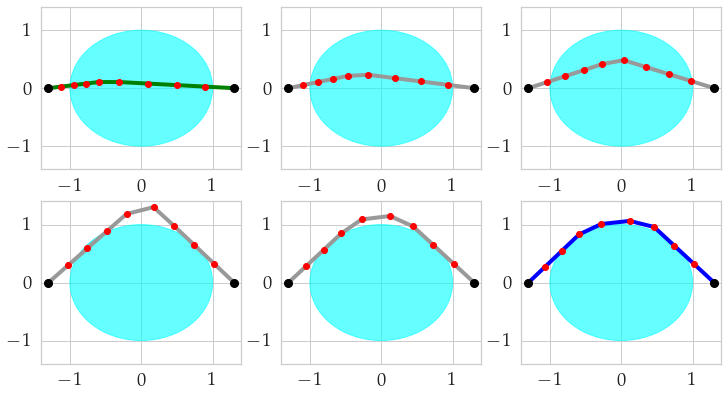

In [28]:
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.7)


selected_epoch = [4, 12, 50, 175]

ncols = 3
nrows = 2

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(5 * nrows, 1.8 * ncols), constrained_layout=True
)

alpha = 0.6
circle = plt.Circle((0, 0), 1.0, color="aqua", fill=True, alpha=alpha)
arr = plot_data[f"epoch_0"]
axs[0, 0].plot(arr[:, 0], arr[:, 1], "g-", linewidth=4)
axs[0, 0].plot(arr[:, 0], arr[:, 1], "ro", markersize=6)
axs[0, 0].add_patch(circle)

axs[0, 0].plot(
    [arr[0, 0], arr[-1, 0]], [arr[0, 1], arr[-1, 1]], "ko", linewidth=2, markersize=8
)

axs[0, 0].set_xlim(-1.4, 1.4)
axs[0, 0].set_ylim(-1.4, 1.4)

for i, key in enumerate(selected_epoch, 1):
    circle = plt.Circle((0, 0), 1.0, color="aqua", fill=True, alpha=alpha)
    r, c = divmod(i, ncols)
    arr = plot_data[f"epoch_{key}"]
    axs[r, c].plot(arr[:, 0], arr[:, 1], color="0.6", linestyle="-", linewidth=4)
    axs[r, c].plot(arr[:, 0], arr[:, 1], "ro", markersize=6)
    axs[r, c].add_patch(circle)

    axs[r, c].plot(
        [arr[0, 0], arr[-1, 0]],
        [arr[0, 1], arr[-1, 1]],
        "ko",
        linewidth=2,
        markersize=8,
    )

    axs[r, c].set_xlim(-1.4, 1.4)
    axs[r, c].set_ylim(-1.4, 1.4)

circle = plt.Circle((0, 0), 1.0, color="aqua", fill=True, alpha=alpha)
arr = plot_data[f"epoch_{num_epoch}"]
axs[nrows - 1, ncols - 1].plot(arr[:, 0], arr[:, 1], "b-", linewidth=4)
axs[nrows - 1, ncols - 1].plot(arr[:, 0], arr[:, 1], "ro", markersize=6)
axs[nrows - 1, ncols - 1].add_patch(circle)

axs[nrows - 1, ncols - 1].plot(
    [arr[0, 0], arr[-1, 0]], [arr[0, 1], arr[-1, 1]], "ko", linewidth=2, markersize=8
)

axs[nrows - 1, ncols - 1].set_xlim(-1.4, 1.4)
axs[nrows - 1, ncols - 1].set_ylim(-1.4, 1.4)

for i in range(len(plot_data), nrows * ncols):
    r, c = divmod(i, ncols)
    axs[r, c].axis("off")

plt.show()
plt.close()

# Ex. 4

Let $M$ be cube surface. Define 
\begin{align*}
d_M(z) & = |1-\|z\|_{\max}|, \\
\mathcal{Q}(z) & = \tfrac{1}{2}\exp(-50 d_M(z)),
\end{align*}
and let $\Phi$ be the identity function. Using the cost function in Eq. (5) (paper), we search for a geodesic $\gamma\colon[0, 1]\to\mathbb{R}^3$ between $z_0=(0, 0, 1)^T$ and $z_1=(1, 0, 0)^T$.

In [290]:
def Q(x, K=50):
    dist = torch.abs(1 - torch.norm(x, p=float("inf"), dim=1, keepdim=True))
    return torch.exp(-K * dist) / 2


def phi(z):
    return z

In [291]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\033[0;1;34mDevice: {device}\033[0m")

z0 = torch.tensor([[0.0, 0.0, 1.0]], device=device, requires_grad=False)
z1 = torch.tensor([[1.0, 0.0, 0.0]], device=device, requires_grad=False)

model = Interpolation([2, 5, 3], z0, z1).to(device)
model

Device: cpu


Interpolation(
  (net): Sequential(
    (dense_0): Linear(in_features=1, out_features=2, bias=True)
    (batchNorm_0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_0): ReLU(inplace=True)
    (dense_1): Linear(in_features=2, out_features=5, bias=True)
    (batchNorm_1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU(inplace=True)
    (dense_2): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [292]:
lr = 0.2
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0)

# use_scheduler = False
use_scheduler = True
if use_scheduler:
    #     scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda epoch: max(0.99 ** epoch, 1e-3 / lr))
    #     scheduler = torch.optim.lr_scheduler.LambdaLR(
    #         optim, lr_lambda=lambda epoch: 0.99 ** epoch if (epoch + 1) % 10 else 1
    #     )
    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optim,
        base_lr=0.001,
        max_lr=lr,
        step_size_up=50,
        mode="triangular2",
        cycle_momentum=False,
    )
    #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10, eta_min=1e-3)
    lrs = []

test = torch.linspace(start=0.0, end=1.0, steps=10, dtype=None, device=None).view(-1, 1)

loss_val = []
num_epoch = 100
# interval, interval_list = 2, [5, 10]
interval, interval_list = 2, [5, 10, 10, 25, 50]
plot_data = {}

vals_k = []
# start_k, end_k = 1, 75
start_k, end_k = 50, 50
for epoch in tqdm(range(num_epoch), leave=False):
    k = min(1, epoch / (num_epoch * 0.8))
    k = k * end_k + (1 - k) * start_k
    vals_k.append(k)

    if epoch % interval == 0:
        plot_data[f"epoch_{epoch}"] = model(test).detach().cpu().numpy()

    batch = torch.rand(50, 1, dtype=torch.float32, device=device, requires_grad=False)
    batch, _ = batch.sort(dim=0, descending=False)
    batch[0, 0] = 0
    batch[-1, 0] = 1

    cost = loss(batch, partial(Q, K=k), phi, model)
    assert torch.isfinite(cost).item(), "Loss has NaN"
    optim.zero_grad()
    cost.backward()
    optim.step()
    loss_val.append(cost.item())

    if (epoch + 1) % 10 == 0:
        try:
            interval = interval_list.pop(0)
        except IndexError:
            pass

    if use_scheduler:
        scheduler.step()
        lrs.append(optim.param_groups[0]["lr"])

plot_data[f"epoch_{num_epoch}"] = model(test).detach().cpu().numpy()

<IPython.core.display.Javascript object>


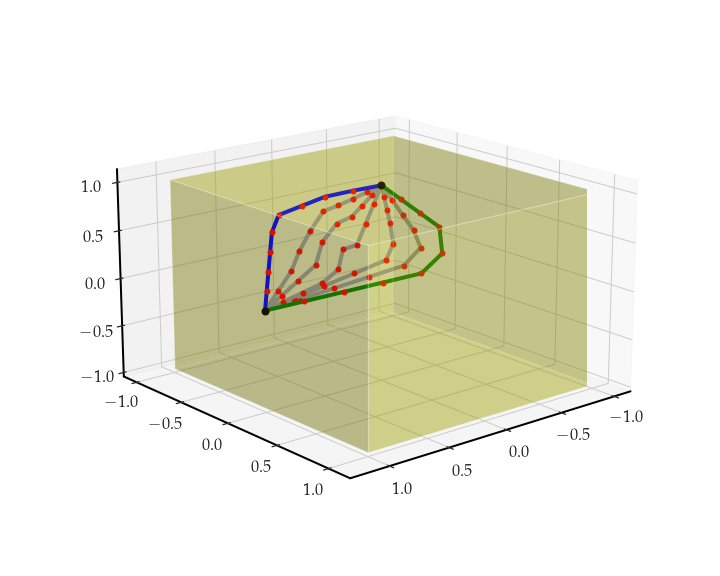

In [29]:
%matplotlib notebook

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)


data = np.ones([2, 2, 2], dtype=np.bool_)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

c = "y"
alpha = 0.25
r = [-1, 1]
X, Y = np.meshgrid(r, r)
one = np.ones(4).reshape(2, 2)

ax.plot_surface(
    X,
    Y,
    one,
    linewidth=1,
    antialiased=False,
    alpha=alpha,
    color=c,
    edgecolor="w",
)
ax.plot_surface(
    X,
    Y,
    -one,
    linewidth=1,
    antialiased=False,
    alpha=alpha,
    color=c,
    edgecolor="w",
)
ax.plot_surface(
    X,
    -one,
    Y,
    linewidth=1,
    antialiased=False,
    alpha=alpha,
    color=c,
    edgecolor="w",
)
ax.plot_surface(
    X,
    one,
    Y,
    linewidth=1,
    antialiased=False,
    alpha=alpha,
    color=c,
    edgecolor="w",
)
ax.plot_surface(
    one,
    X,
    Y,
    linewidth=1,
    antialiased=False,
    alpha=alpha,
    color=c,
    edgecolor="w",
)
ax.plot_surface(
    -one,
    X,
    Y,
    linewidth=1,
    antialiased=False,
    alpha=alpha,
    color=c,
    edgecolor="w",
)

selected_epoch = [6, 10, 15, 20, 30]

for key in selected_epoch:
    path = plot_data[f"epoch_{key}"]
    ax.plot(path[:, 0], path[:, 1], path[:, 2], color="0.6", linestyle="-", linewidth=4)
    ax.plot(path[:, 0], path[:, 1], path[:, 2], "ro", markersize=5)


path = plot_data[f"epoch_0"]
ax.plot(path[:, 0], path[:, 1], path[:, 2], "g-", linewidth=4)
ax.plot(path[:, 0], path[:, 1], path[:, 2], "ro", markersize=5)

path = plot_data[f"epoch_{num_epoch}"]
ax.plot(path[:, 0], path[:, 1], path[:, 2], "b-", linewidth=4)
ax.plot(path[:, 0], path[:, 1], path[:, 2], "ro", markersize=5)

ax.plot(
    [path[0, 0], path[-1, 0]],
    [path[0, 1], path[-1, 1]],
    [path[0, 2], path[-1, 2]],
    "ko",
    linewidth=2,
    markersize=7,
)

ax.set_box_aspect(aspect=(1, 1, 0.6))

azim = 50
dist = 8
elev = 17

ax.azim = azim
ax.dist = dist
ax.elev = elev

ax.w_xaxis.line.update({"linewidth": 2, "color": "k"})
ax.w_yaxis.line.update({"linewidth": 2, "color": "k"})
ax.w_zaxis.line.update({"linewidth": 2, "color": "k"})

plt.show()
# plt.close(fig)